# <center>NBA Player Evolution Analysis </center>
#### <center> Author: Pablo Gomez </center>
#### <center> 2023-03-26 </center>

#### __Contextual Review__

I will look to analyze the historical trend of National Basketball Association (__NBA__) players over the past 70 years. In the broad view, the NBA seems to have increased the pool of talent, with players having improved their technical abilities over the past decades. As a fan, I can identify some of these trends instinctually as I see taller positional Point Guards(__PG__) like _Shai Gilgeous-Alexander_, who is 6'6'', or players with longer reach like _Mikal Bridges_ who has a wingspan of 7'1''. In many ways, these physical advantages in my opinion have led to me less and fewer short players for their respective position like _Isaiah Thomas_ for Point Guard, who is 5'9'' tall,  or _Charles Barkley_ for Power Forward(__PF__) who is 6'6''. 

In this Analysis, I want to support or rebute this instinctual theory or observation, and see how the height and wingspan of the average NBA player has evolved over time for their respective in-game position. In addition, I want to see how the variation of these physical attributes has evolved over time and see if there has been a trend of uniformity of the NBA player. Measuring this variance will show if there has been increased uniqueness or standardization of the typical NBA player.

To Summarize we will look:
1. See trends in median heights of NBA players per position over time.
2. See the trends in the variation of heights for NBA players over time.
3. See trends in median wingspan lengths of NBA players per position over time.
4. See the trends in the variation of wingspan lengths for NBA players over time

#### __Data Collection__

Looking at how I collected the data for this analysis, I used many sources to fit together a complete analysis from 1950-2022. First, the year-by-year analysis of players who played for in the specific season year was collected in two parts:
1. By a popular publicaly shared [Kaggle dataset](https://www.kaggle.com/datasets/drgilermo/nba-players-stats?select=Seasons_Stats.csv) that includes 3 tables, specifially in question the `Season_Stats.csv` data file.
2. Since the `Season_Stats.csv` contains stats until 2017, I had to go to [Basketball Reference](http://https://www.basketball-reference.com/) and go year by year to obtain csv files for each individual year to complete the year-by-year players.

Now looking at how I collected the physical measurements of the players. Again, the data was collected in two parts:
1. The same Kaggle dataset has a different data frame titled `player_data.csv`, which includes many variables, including the player's height.
2. Since the Kaggle dataset is limited by the maximum year being 2017, I had to include additional external sources from Kaggle, called [NBA Database](https://www.kaggle.com/datasets/wyattowalsh/basketball), which has all types of tables including the `common_player_info` table. This database was only accessible using __SQL__. Therefore in the Python code the SQL `SQLite` is used to retrieve the relevant data. In this database, you have wingspan information that is only accessible for the years 2001 and on. In addition, the final height measurements for the 2017-2022 period are also accessed using this database. 

#### __Pre-processing/munging__

Necessary steps used to do analysis:

1. Import necessary Python packages:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import sqlite3

2. Retrieve relevant data from out data sources by using `read_csv` or `sqlite.connect` objects:

In [2]:
# Use to identify current work folder directory
pwd = os.getcwd()

# Retreive the necessary columns, to not demand as much of our computational capacities
pre_2017_physicals = pd.read_csv(pwd+"\\player_data.csv",usecols=['name','height','weight'])
season_csv = pd.read_csv(pwd+"\\Seasons_Stats.csv",usecols=['Player','Year','Pos','Age','G','MP'])

conn = sqlite3.connect(pwd+'/nba.sqlite') # create connection object to database
# Retrieve relevant data from database using SQL commands
physicals = pd.read_sql('select first_name, last_name, position, height_wo_shoes_ft_in, weight,wingspan_ft_in from draft_combine_stats',conn)
wingspan = pd.read_sql('select player_name,wingspan from draft_combine_stats',conn)
post_2017_physicals = pd.read_sql('select display_first_last,height,weight from common_player_info',conn)

# Retreive individual year-by-year NBA season totals
Totals_2018 = pd.read_csv(pwd+"\\2018_NBA_TOTALS.csv")
Totals_2019 = pd.read_csv(pwd+"\\2019_NBA_TOTALS.csv")
Totals_2020 = pd.read_csv(pwd+"\\2020_NBA_TOTALS.csv")
Totals_2021 = pd.read_csv(pwd+"\\2021_NBA_TOTALS.csv")
Totals_2022 = pd.read_csv(pwd+"\\2022_NBA_TOTALS.csv")

3. Clean Up Relevant Data
- Consolidate Pre-2017 tables

In [3]:
# Rename to 'Player' column to uniform column name
pre_2017_physicals.rename(columns={'name': 'Player'}, inplace=True) 

pre_2017 = season_csv.merge(pre_2017_physicals,on=['Player'],how='inner')

- Consolidate Post-2017 Tables

In [4]:
# Give each indice a specific Year value
Totals_2018['Year'] = 2018
Totals_2019['Year'] = 2019
Totals_2020['Year'] = 2020
Totals_2021['Year'] = 2021
Totals_2022['Year'] = 2022

#Consolidate each individual year data frame
post_2017_season = pd.concat([Totals_2018,Totals_2019,Totals_2020,Totals_2021,Totals_2022],axis=0,ignore_index=True)
# Create uniformity in variables titles for easy integration
post_2017_season = post_2017_season[['Player', 'Year', 'Pos', 'Age', 'G', 'MP']]
# Rename a column
post_2017_physicals.rename(columns={'display_first_last': 'Player'}, inplace=True)
# Combine on 'Player' Index
post_2017 = post_2017_season.merge(post_2017_physicals,on='Player',how='inner')

- Consolidate the complete the Pre-2017 and Post-2017 Dataframe

In [5]:
# Create variable uniformity amongst both data frames
post_2017 = post_2017[['Player', 'Year', 'Pos', 'Age', 'G', 'MP', 'height',
       'weight']]

nba_df = pd.concat([pre_2017,post_2017],axis=0,ignore_index=True)

- Join additional information on the players wingspan

In [6]:
#Create variable name uniformity
wingspan.rename(columns={'player_name': 'Player'}, inplace=True)

nba_df = nba_df.merge(wingspan,on='Player',how='left')

- Transform different variables like 'height' to be able to display in common know format of `feet'inches''` manner for later visualization

In [7]:
# Clean some null values in the data, especially the height variable that has 
nba_df['height'] = nba_df['height'].astype(str)
nba_df = nba_df.dropna(subset=['height'],inplace=False)
nba_df.drop([5121,5122],inplace=True)

# To transform into inches for easier manipulation
def height_to_inches(height):
    feet, inches = height.split("-")
    return int(feet) * 12 + int(inches)

def inches_to_height(height_inches):
    feet = int(height_inches // 12)
    inches = int(height_inches % 12)
    return f"{feet}'{inches}\""

nba_df["height_inches"] = nba_df["height"].apply(height_to_inches)
# Some positions contain two positions, create primary position variable
nba_df['primary_pos'] = nba_df['Pos'].str.split('-').str[0]

# Some positions before 1970s are in F or G, since back then was not as specialized, I ordered them based on conditional formatting of height and position
nba_df.loc[(nba_df['primary_pos']=='G')&(nba_df['height_inches'] <=76),'primary_pos'] = 'PG'
nba_df.loc[(nba_df['primary_pos']=='G')&(nba_df['height_inches'] >76),'primary_pos'] = 'SG'
nba_df.loc[(nba_df['primary_pos']=='F')&(nba_df['height_inches'] <=81),'primary_pos'] = 'SF'
nba_df.loc[(nba_df['primary_pos']=='F')&(nba_df['height_inches'] >=81),'primary_pos'] = 'PF'

nba_df.groupby(by=['Player','Year'])

# Some players appear multiple times per year since they were traded, there is a total column, grouping just coalesces the data
nba_df = nba_df.groupby(by=['Player', 'Year', 'Pos', 'Age', 'height',
       'weight', 'wingspan', 'height_inches', 'primary_pos'],dropna=False).agg({'G': 'max','MP':'max'}).reset_index().sort_values(['Year','Player'])

#### __Analysis__
1. Median Height Analysis

- Looking at the analysis of Median height, it is important to state median is the best form of measuring central tendency. In this analysis or collection of data before we use summarizing tools like `groupby` to illustrate a year-by-year, position by position trend. After that grouping, we will display the results in a visualization using seaborn. We will choose a line plot since it is simple but effective in displaying the relevant results.

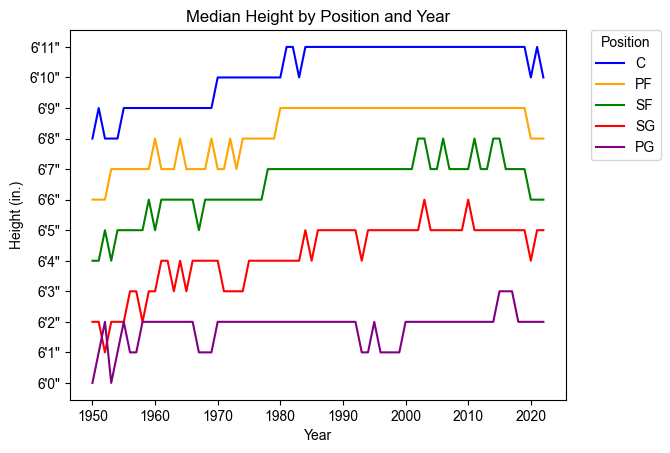

In [8]:
# Set color pallette for uniform positional color
color_palette = {'PG':'purple','SG':'red','SF':'green','PF':'orange','C':'blue'}
# Group and aggregate by median and later change from inches in the feet'inches'' display
median_height = nba_df.groupby(by=['Year','primary_pos']).agg({'height_inches':'median'}).reset_index().sort_values('height_inches',ascending = False)
median_height['height'] = median_height['height_inches'].apply(inches_to_height)

g = sns.lineplot(x = 'Year',y='height',hue = 'primary_pos',data = median_height,palette=color_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Position')
g.set_ylabel('Height (in.)')

plt.title('Median Height by Position and Year')
sns.set_style('darkgrid')

- Looking at the results of the visualization we find that there practically has not been a change in the median height of players for any position in recent history. We really see the evolution of the game in the early part of the timeline, in particular from the 1950s to the 1980s period. We see about a growth of 2 inches for each position during that period. Players like _Shai Gilgeous-Alexander_ must be outliers in the view. I guess players like _Magic Johnson_ would be anomalies for their times.

2. Variation Height Analysis

- Looking at the analysis of Average variance in height, it is important to state that the measurement of average variance in height per player is important in measuring how much uniformity or amount of players are of that specific height. The lower the variance, the higher the population of players of that specific height.
- When measuring variance we will use the summary statistic of standard deviation since it is the proper measurement of the average variation of a variable. 

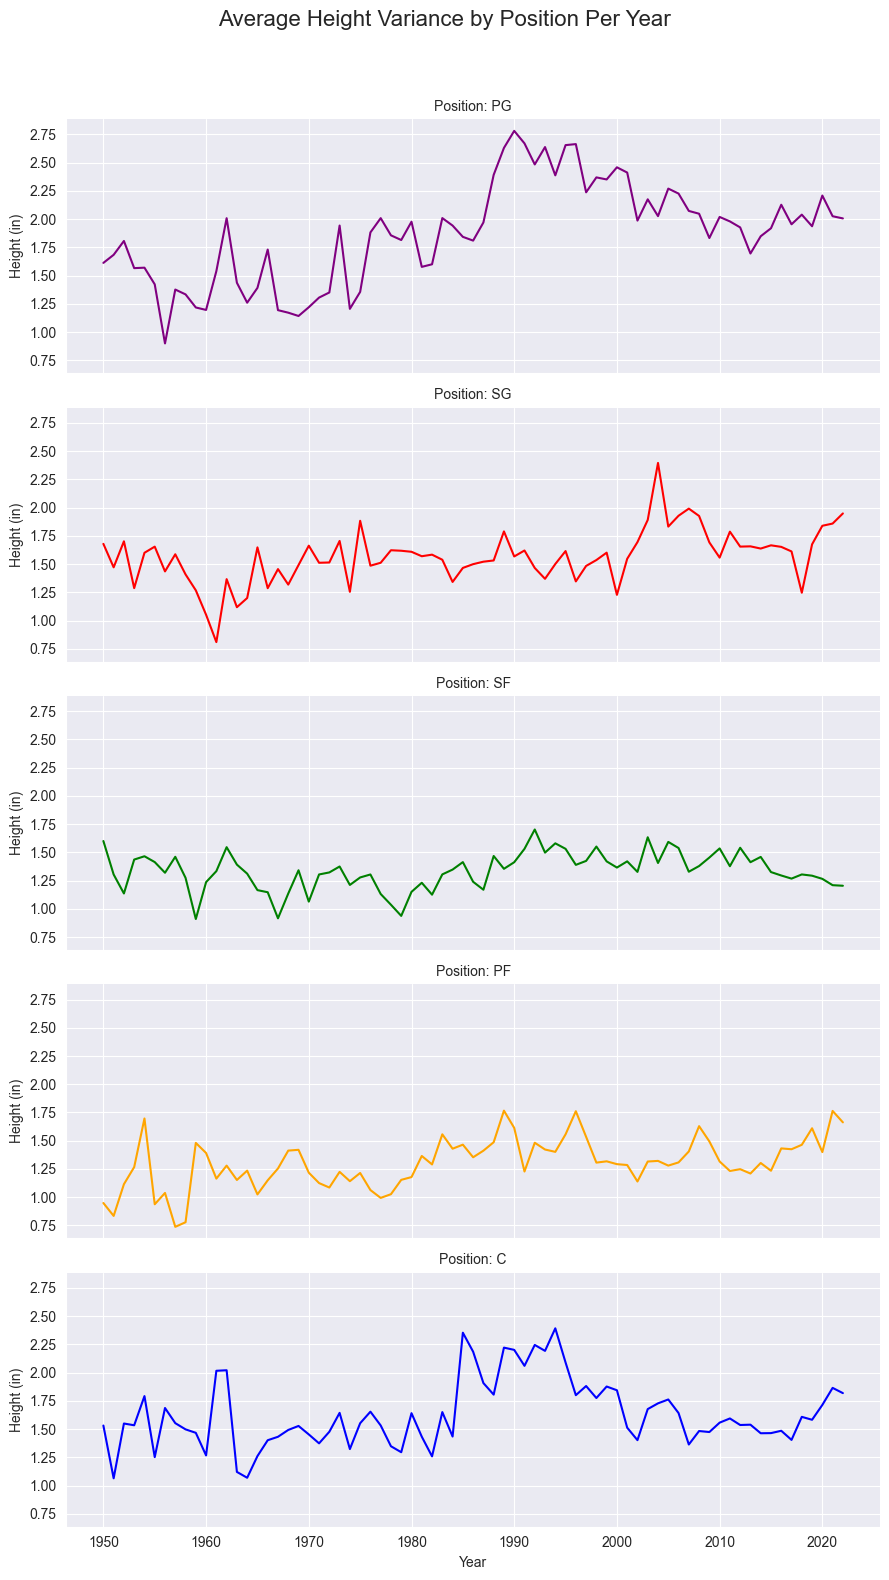

In [9]:
color_palette = {'PG':'purple','SG':'red','SF':'green','PF':'orange','C':'blue'}
# Group and aggregate by standard deviation
sd_height = nba_df.groupby(by=['Year', 'primary_pos']).agg({'height_inches': 'std'}).reset_index()
# Create facet grid to declutter the chaos in variation, to clearly help distinguish postion
g = sns.FacetGrid(data=sd_height, row='primary_pos', row_order=['PG', 'SG', 'SF', 'PF', 'C'], height=3, aspect=3)
g.map(sns.lineplot, 'Year', 'height_inches',hue=sd_height['primary_pos'],palette=color_palette)
sns.set_style('darkgrid')
g.set_titles("Position: {row_name}")
g.set_xlabels('Year')
g.set_ylabels('Height (in)')

g.fig.suptitle('Average Height Variance by Position Per Year', y=1.05, fontsize=16)
plt.show()

- In the following results we really do not see any significant trends in the data. In reality, there is a lot of fluctuation in the data of average variance per year per position. The only noticeable trend in our data has to do with the Small-Forward (SF) position in the data with the consistency of the average variance in the height in addition to the averages being relatively low compared to the other positions. The data hovers around `1.25''` on average telling us that SFs in the NBA are pretty uniform in their height. Most of the SFs in the NBA are `6'7''` with an average give or take of `1.25` inches in their height.

3. Median Wingspan Lengths Analysis

- The median wingspan analysis is similar to that of the median height analysis. We use `median` as the measurement since it is the best form of measurement for central tendency, affected less by outliers.
- In addition, we will display the wingspan in `inches` since we want to display the precise discrepancies measured we collecting the wingspan data.
- Important to state the dates for this data will be filtered from `2001-2022` since a lot of wingspan data collection occurred from `2000` and on.

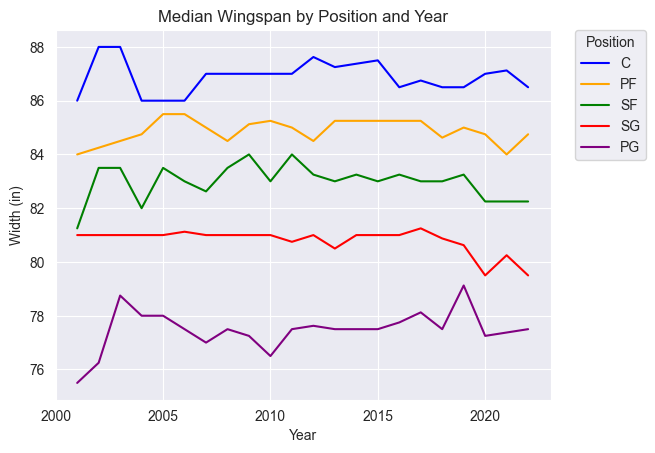

In [10]:
# Group and aggregate by median wingspan
median_wingspan = nba_df.groupby(by=['Year','primary_pos']).agg({'wingspan':'median'}).reset_index().sort_values('wingspan',ascending = False)
median_wingspan = median_wingspan.loc[median_wingspan['Year']>=2001] # Filter the relevant dates in the data frame

color_palette = {'PG':'purple','SG':'red','SF':'green','PF':'orange','C':'blue'}

g = sns.lineplot(x = 'Year',y='wingspan',hue = 'primary_pos',data = median_wingspan,palette=color_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Position')
g.set_ylabel('Width (in)')
plt.title('Median Wingspan by Position and Year')
sns.set_style('darkgrid')

- Our results show about the same trend, or lack of trend, from the height analysis. In reality, this trend should be on par since there are implied correlations that the taller a person is the longer the wingspan they have. Nonetheless, in the visualization, we a noticeable point in the SG position, being that the width over the past 5 years has decreased. Another implication from this point is that SG has been forced to become better three-point shooters, and there is an implied judgment that the shorter the wingspan the more success the player has in knocking down shots.

4. Average Variation Wingspan Lengths Analysis

- This average variation analysis will be conducted in a similar manner to that of the Average variance height analysis. We want to check for the uniformity of the wingspan lengths, specifically if there are any acceptable discrepancies for NBA players.
- We will check the average variation using the statistical tool of `standard deviation`.

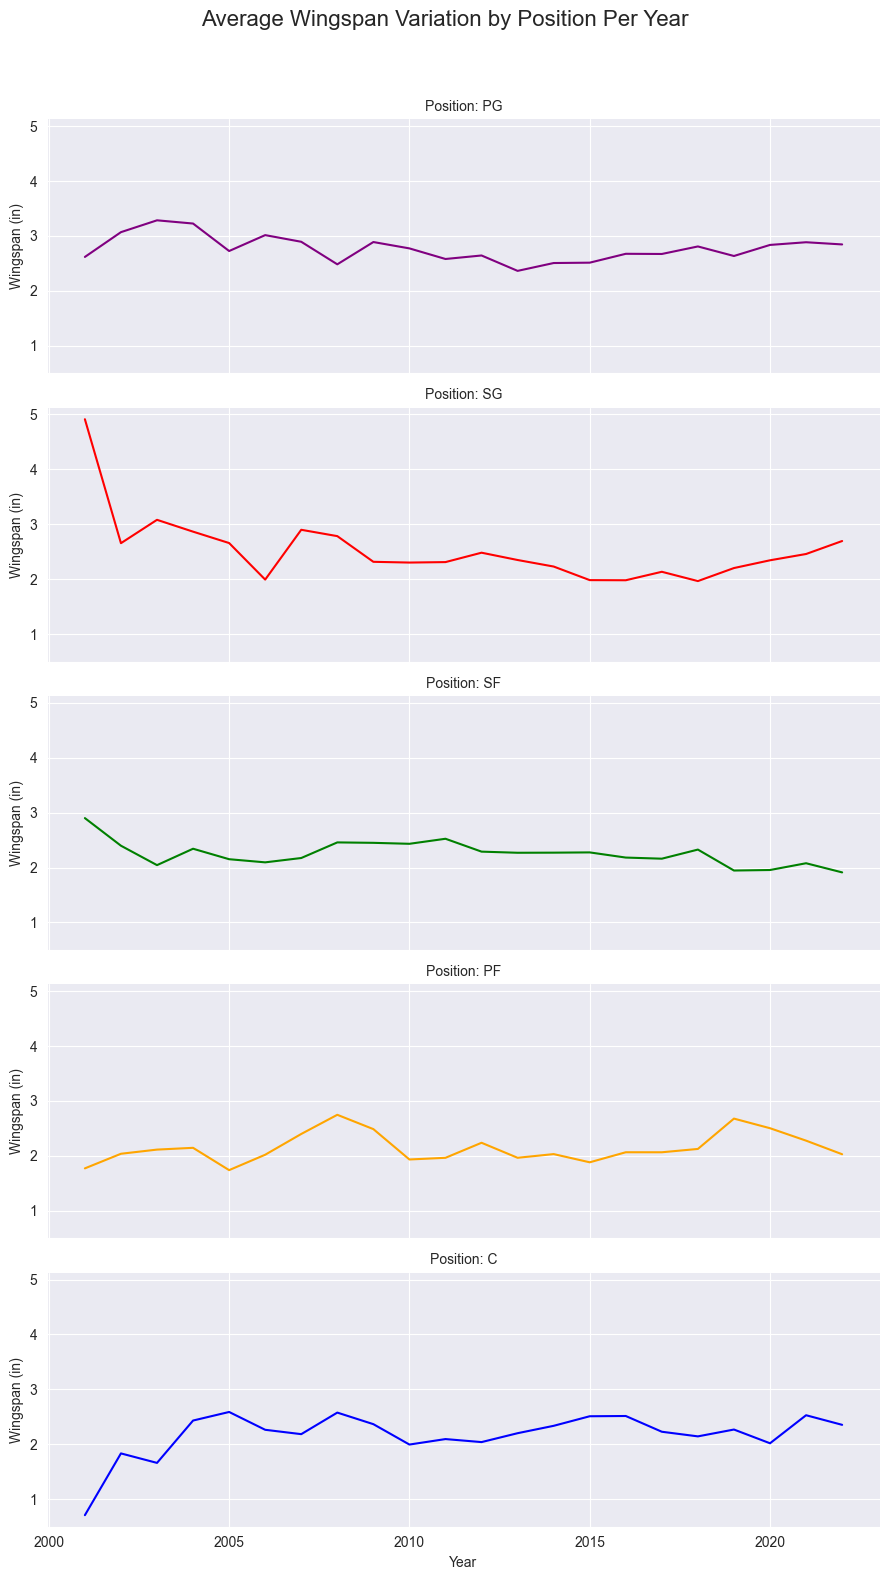

In [11]:
# Group and aggregate by standard deviation wingspan
sd_wingspan = nba_df.groupby(by=['Year','primary_pos']).agg({'wingspan':'std'}).reset_index().sort_values('wingspan',ascending = False)
sd_wingspan = sd_wingspan.loc[sd_wingspan['Year']>=2001] # Filter the relevant dates in the data frame
# Create facet grid to declutter the chaos in variation, to clearly help distinguish postion
g = sns.FacetGrid(data=sd_wingspan, row='primary_pos', row_order=['PG', 'SG', 'SF', 'PF', 'C'], height=3, aspect=3)
g.map(sns.lineplot, 'Year', 'wingspan',hue=sd_wingspan['primary_pos'],palette=color_palette)

sns.set_style('darkgrid')
g.set_titles("Position: {row_name}")
g.set_xlabels('Year')
g.set_ylabels('Wingspan (in)')

g.fig.suptitle('Average Wingspan Variation by Position Per Year', y=1.05, fontsize=16)
plt.show()

- In these results, we find pretty consistent trends for each of the various positions. The trend is more or less a lack of trend that average variation remains consistent overtime. We do not see the same fluctuation as that in of the height variation visualization. This data tell us that no uniformity or uniqueness if a player's wingspans have increased overtime. 

#### __Conclusion__
We began the analysis by identifying my perspective on certain implied NBA trends to later challenge and take on in this analysis. This identified 'theory' or 'hypothesis' was related to the average player's height and wingspan. I mentioned specific examples of witnessing popular players like `Shai Gilgeous-Alexander` and `Kevin Durant` who are significantly tall for their respective positions at `6'6''` and `6'11''`. In addition, I made specific observations of long wingspan players like `Mikal Bridges` who has a `7'1''` wingspan. I put my observations to the test with various analyses.

Beginning with the Height analysis we found no support that players are taller now than ever. At the beginning of the timeline of data measurements from 1950-1980, we do see an increase in heights of about 2 inches. In the variation analysis of height, we found the average variation to fluctuate and not create any noteworthy trend, showing that there really is no increase in uniqueness or uniformity in heights per position. These analyses disprove my observations believing the average NBA player has become taller.

With the Wingspan analysis, we find no support that the overtime there have been players with longer wingspans. The data showed us that the median wingspan width has not really changed over the past 20 years, in reality, the data has been relatively consistent. The variance analysis shows the consistent average variance throughout the past 20 years. This shows us no real increase in uniqueness or uniformity in wingspan per position. Both of these analyses disprove my assumptions of believing the average NBA player has become longer. 

Overall, the analysis was successful in disproving my observations of players. I notice that the players I mentioned as anomalies are just that, anomalies. I do notice that these players I mentioned are actually superstars of the league, and I wonder if there is any argument to be made that having increased height or wingspan gives a player better results. If there is a continuation of this analysis I would investigate the relationship between performance and physical attributes. 